In [1]:
import pandas as pd
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN, KMeans
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

from nltk.corpus import stopwords, wordnet, words
from nltk.tokenize import PunktSentenceTokenizer, MWETokenizer, sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag

from textblob import TextBlob
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage
from pprint import pprint
from pymongo import MongoClient
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/markdziuban/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/markdziuban/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/markdziuban/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!


True

In [3]:
client = MongoClient()
db = client.wheel_of_time

In [4]:
def book_to_df(collection):
    ''' Takes in a collection from a database (mongoDB) and returns a dataframe with the each book as a collection'''
    cursor = collection.find({},{'_id':0})
    for document in cursor:
        doc_book = document
    key_book = list(doc_book.keys())[0] 
    chapters = doc_book[key_book]
    dictlist = []
    chap_dict = {}
    for i, (key, value) in enumerate(chapters.items()):
        chap_dict[i] = value 
    df = pd.DataFrame.from_dict(chap_dict, orient='index')
    df['Chapter_Number'] = chap_dict.keys()
    df['Book_Title'] = key_book
    return df

In [5]:
books = 14
books_df = pd.DataFrame(columns=['Book_Title','Chapter_Text','Chapter_Number'])
for i in range(books):
    collection = db['book{}'.format(i+1)]
    result = book_to_df(collection)
    result = result.rename(columns={0:'Chapter_Text'})
    books_df = pd.concat([books_df, result], ignore_index=True)

In [6]:
book_to_df(collection)

0  Chapter_Number  \
0   Bayrd pressed the coin between his thumb and f...               0   
1   A Knack81114161922In the end, the solution had...               1   
2   1\nEastward the Wind BlewThe Wheel of Time tur...               2   
3   2\nThe Choke of an AjahPevara did her very bes...               3   
4   3\nA Dangerous Place“ V ord Logain and Taim ha...               4   
5   4\nAdvantages to a Bondnd that was the end of ...               5   
6   5\nTo Require a BoonRand al’Thor awoke and dre...               6   
7   6Much of it was directed at the woman standing...               7   
8   7\nInto the Thick of ItElayne stepped out of t...               8   
9   8\nThat Smoldering CityAtop Moonshadow, her de...               9   
10  9“Lord Mandragoran!” Lan wheeled toward the ca...              10   
11  10\nThe Use of DragonsPerrin rode Stayer, ligh...              11   
12  11\nJust Another Sell-swordI realize there hav...              12   
13  12\nA Shard of a MomentBirgitte dashed through...              13   
14  13\nWhat Must Be DoneThe army split before Egw...              14   
15  14\nDoses of Forkroot“ IT ight . . ” Perrin wh...              15   
16  15\nYour Neck in a CordThe Tarasin Palace of E...              16   
17  16\nA Silence Like ScreamingLoial, son of Aren...              17   
18  17\nOlder, More Weathered\n*y^\TmT as not frui...              18   
19  18\nTo Feel WastedGawyn stood on a field near ...              19   
20  19\nThe Choke of a PatchElayne found Bashere p...              20   
21  20\nInto Thakari'darLater in the day after her...              21   
22  21\nNot a Mistake to IgnoreSiuan rolled her sh...              22   
23  22\nThe WyldEgwene was shocked awake as Gawyn ...              23   
24  23\nAt the Edge of TimeGawyn tugged urgently o...              24   
25  24The throne lent her grandeur, but also gave ...              25   
26  25\nQuick FragmentsSiuan let out a long, relie...              26   
27  26She didn’t like it either, and she knew he w...              27   
28  27fl. \nFriendly FireGareth Bryne strode throu...              28   
29  28\nToo Many MenLord Agelmar sent us directly,...              29   
30  29\nNo wonder I had trouble spotting him,  Egw...              30   
31  30\nThe Way of the PredatorPerrin and Gaul did...              31   
32  31The camp continued to fill with Aes Sedai an...              32   
33  32\nA Yellow Flower-SpiderThe damane held open...              33   
34  33He leaped from a churning, silver-black clou...              34   
35  34\nDriftingRand stood in a place that was not...              35   
36  35He wiped his brow. The Blight was pretty sca...              36   
37  36\nUnchangeable ThingsSomething was wrong wit...              37   
38  37\nThe Last BattleDawn broke that morning on ...              38   
39  38\nLet go.  His fathers voice. “I have to sav...              39   
40  39YOU, the Dark One replied. I HAVE YOU. Rand ...              40   
41  40\nWolfbrotherElayne’s captors looked at Birg...              41   
42  41Pounding echoed across the top of the Height...              42   
43  42The lightning that fell on the valley of Sha...              43   
44  43“I guess they probably won’t need you,” Gabr...              44   
45  44\nTwo CraftsmenPerrin awoke to something rus...              45   
46  45\nTendrils of MistDice tumbling in his head,...              46   
47  46\nTo AwakenRand broke free from the darkness...              47   
48  47She fought it off, but barely. The Forsaken ...              48   
49  48So many dead. Hundreds of thousands of men a...              49   
50  49Beneath that was only emptiness. In the wolf...              50   

              Book_Title  
0   14 A Memory of Light  
1   14 A Memory of Light  
2   14 A Memory of Light  
3   14 A Memory of Light  
4   14 A Memory of Light  
5   14 A Memory of Light  
6   14 A Memory of Light  
7   14 A Memory of Light  
8   14 A Mem

In [7]:
indexNames = books_df[(books_df['Book_Title']=='14 A Memory of Light') & (books_df['Chapter_Number'] == 38)].index
 
# Delete these row indexes from dataFrame
books_df.drop(indexNames , inplace=True)

In [8]:
# Adding two chapters from books not in the series by both authors for testing.

with open("/Users/markdziuban/Desktop/workspace/brandonSanderson.txt") as file:
   brandon_sanderson = file.read()
with open("/Users/markdziuban/Documents/robertjordan2.txt") as file:
   robert_jordan = file.read()

In [9]:
data = [['BrandonSandersonExtra', brandon_sanderson, 0]] 
bs = pd.DataFrame(data, columns=['Book_Title','Chapter_Text','Chapter_Number'])
bs

Book_Title                                       Chapter_Text  \
0  BrandonSandersonExtra  Dalinar Kholin appeared in the vision standing...   

   Chapter_Number  
0               0

In [10]:
data = [['RobertJordan',robert_jordan,0]]
rj = pd.DataFrame(data, columns=['Book_Title','Chapter_Text','Chapter_Number'])
rj

Book_Title                                       Chapter_Text  \
0  RobertJordan  The wide corridor outside the Amyrlin's apartm...   

   Chapter_Number  
0               0

In [11]:
books_df = pd.concat([books_df, rj], ignore_index=True)
books_df = pd.concat([books_df, bs], ignore_index=True)
books_df

Book_Title  \
0    01 The Eye of the World   
1    01 The Eye of the World   
2    01 The Eye of the World   
3    01 The Eye of the World   
4    01 The Eye of the World   
..                       ...   
669     14 A Memory of Light   
670     14 A Memory of Light   
671     14 A Memory of Light   
672             RobertJordan   
673    BrandonSandersonExtra   

                                          Chapter_Text Chapter_Number  
0    PROLOGUE\nDragonmountThe palace still shook oc...              0  
1    1\nAn Empty RoadThe Wheel of Time turns, and A...              1  
2    2\nStrangersWhen Rand and Mat carried the firs...              2  
3    3\nThe PeddlerClusters of pots clattered and b...              3  
4    4\nThe GleemanThe door of the inn banged shut ...              4  
..                                                 ...            ...  
669  47She fought it off, but barely. The Forsaken ...             48  
670  48So many dead. Hundreds of thousands of men a...             49  
671  49Beneath that was only emptiness. In the wolf...             50  
672  The wide corridor outside the Amyrlin's apartm...              0  
673  Dalinar Kholin appeared in the vision standing...              0  

[674 rows x 3 columns]

## Tokenization

In [12]:
# Tokenization by Sentence
sent_df = books_df.copy()
sent_df['Chap_by_Sent'] = sent_df['Chapter_Text'].apply(sent_tokenize)

In [13]:
# Tokenization by Word
words_df = books_df.copy()
words_df['Words'] = words_df['Chapter_Text'].apply(word_tokenize)

## Remove

In [14]:
# Apply a first round of text cleaning techniques
import re
import string

def clean_text_round1(text_list):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    result = []
    for text in text_list:
        text = text.lower()
        text = re.sub('\[.*?\]', ' ', text)
        text = re.sub('[0-9]', ' ', text)
        #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        text = re.sub('\w*\d\w*', ' ', text)
        result.append(text)
    return result

round1 = lambda x: clean_text_round1(x)

In [15]:
sent_df['Chap_by_Sent'] = sent_df['Chap_by_Sent'].apply(round1)

In [16]:
# Apply a second round of cleaning
def clean_text_round2(text_list):
    '''Get rid of some additional punctuation and non-sensical text that was missed the first time around.'''
    result = []
    for text in text_list:
        text = re.sub('[‘’“”…]', '', text)
        text = re.sub('\n', ' ', text)
        result.append(text)
    return result

round2 = lambda x: clean_text_round2(x)

In [17]:
sent_df['Chap_by_Sent'] = sent_df['Chap_by_Sent'].apply(round2)


In [18]:
stopwords = nltk.corpus.stopwords.words('english')
newStopWords = ['stopWord1','stopWord2']
stopwords.extend(newStopWords)

## Chunking

In [19]:

mwe_tokenizer = MWETokenizer([('aes','sedai')])
#mwe_tokens = mwe_tokenizer.tokenize(sent_tokenize(my_text))

In [20]:
def token_list(word_list):
    result = []
    for word in word_list:
        mwe_tokens = mwe_tokenizer.tokenize(word_tokenize(word))
        result.append(mwe_tokens)
    return result

In [21]:
sent_df['Word_Tokens'] = sent_df['Chap_by_Sent'].apply(token_list)

In [22]:
def join_sent(sent_list):
    result = []
    for sent in sent_list:
        sent_res = " ".join(sent)
        result.append(sent_res)
    return result



sent_df['Chap_by_Sent'] = sent_df['Word_Tokens'].apply(join_sent)
sent_df['Chap_by_Sent'][0]

['prologue dragonmountthe palace still shook occasionally as the earth rumbled in memory , groaned as if it woulddeny what had happened .',
 'bars of sunlight cast through rents in the walls made motes of dust glitterwhere they yet hung in the air .',
 'scorch-marks marred the walls , the floors , the ceilings .',
 'broad blacksmears crossed the blistered paints and gilt of once-bright murals , soot overlaying crumbling friezesof men and animals which seemed to have attempted to walk before the madness grew quiet .',
 'the dead lay everywhere , men and women and children , struck down in attempted flight by the lightningsthat had flashed down every corridor , or seized by the fires that had stalked them , or sunken into stoneof the palace , the stones that had flowed and sought , almost alive , before stillness came again .',
 'in oddcounterpoint , colorful tapestries and paintings , masterworks all , hung undisturbed except wherebulging walls had pushed them awry .',
 'finely carved f

In [23]:
from nltk.chunk import ne_chunk
from nltk.tag import pos_tag

my_text = sent_df['Chapter_Text'][0]
tokens = pos_tag(word_tokenize(my_text))
entities = ne_chunk(tokens)

## Stemming / Parts of Speech / Misspellings

In [24]:
# Search through each document and try to determine the chapter character point of view
# Set all as not main to start and then assign them.  If it is not one of the 6 main, then leave as not main
sent_df['POV'] = 'Not-main'
rand = "rand"
perrin = "perrin"
mat = "mat"
egwene = "egwene"
nynaeve = "nynaeve"
elayne = "elayne"

def check_pov(text_list):
    for sent in text_list[:20]:
        for word in sent:
            if word == rand:
                return rand
            elif word == perrin:
                return perrin
            elif word == mat:
                return mat
            elif word == egwene:
                return egwene
            elif word == nynaeve:
                return nynaeve
            elif word == elayne:
                return elayne
    return 'Not_Main'
            

In [25]:
sent_df['POV'] = sent_df['Word_Tokens'].apply(check_pov)
sent_df

Book_Title  \
0    01 The Eye of the World   
1    01 The Eye of the World   
2    01 The Eye of the World   
3    01 The Eye of the World   
4    01 The Eye of the World   
..                       ...   
669     14 A Memory of Light   
670     14 A Memory of Light   
671     14 A Memory of Light   
672             RobertJordan   
673    BrandonSandersonExtra   

                                          Chapter_Text Chapter_Number  \
0    PROLOGUE\nDragonmountThe palace still shook oc...              0   
1    1\nAn Empty RoadThe Wheel of Time turns, and A...              1   
2    2\nStrangersWhen Rand and Mat carried the firs...              2   
3    3\nThe PeddlerClusters of pots clattered and b...              3   
4    4\nThe GleemanThe door of the inn banged shut ...              4   
..                                                 ...            ...   
669  47She fought it off, but barely. The Forsaken ...             48   
670  48So many dead. Hundreds of thousands of men a...             49   
671  49Beneath that was only emptiness. In the wolf...             50   
672  The wide corridor outside the Amyrlin's apartm...              0   
673  Dalinar Kholin appeared in the vision standing...              0   

                                          Chap_by_Sent  \
0    [prologue dragonmountthe palace still shook oc...   
1    [an empty roadthe wheel of time turns , and ag...   
2    [strangerswhen rand and mat carried the first ...   
3    [the peddlerclusters of pots clattered and ban...   
4    [the gleemanthe door of the inn banged shut be...   
..                                                 ...   
669  [she fought it off , but barely ., the forsake...   
670  [so many dead ., hundreds of thousands of men ...   
671  [beneath that was only emptiness ., in the wol...   
672  [the wide corridor outside the amyrlin 's apar...   
673  [dalinar kholin appeared in the vision standin...   

                                           Word_Tokens       POV  
0    [[prologue, dragonmountthe, palace, still, sho...  Not_Main  
1    [[an, empty, roadthe, wheel, of, time, turns, ...      rand  
2    [[strangerswhen, rand, and, mat, carried, the,...      rand  
3    [[the, peddlerclusters, of, pots, clattered, a...      rand  
4    [[the, gleemanthe, door, of, the, inn, banged,...      rand  
..                                                 ...       ...  
669  [[she, fought, it, off, ,, but, barely, .], [t...  Not_Main  
670  [[so, many, dead, .], [hundreds, of, thousands...    elayne  
671  [[beneath, that, was, only, emptiness, .], [in...    perrin  
672  [[the, wide, corridor, outside, the, amyrlin, ...  Not_Main  
673  [[dalinar, kholin, appeared, in, the, vision, ...  Not_Main  

[674 rows x 6 columns]

In [26]:
main = list(sent_df['POV'])

In [27]:
sent_df['POV'].value_counts()

Not_Main    159
rand        150
egwene       87
perrin       85
mat          79
elayne       57
nynaeve      57
Name: POV, dtype: int64

In [28]:
#clean_df = books_df.copy()

clean_df = sent_df.copy()

In [29]:
lemmatizer = WordNetLemmatizer()
def lem_clean(chap):
    result = []
    for sent in chap:
        for w in sent:
            #filtered_sentence = [w for w in word_list if not w in stopwords]
            #print(filtered_sentence)
            #for w in word_list:
            w = lemmatizer.lemmatize(w)
            result.append(w)
    #return " ".join(filtered_sentence)
    return result

In [30]:
clean_df['Word_Tokens'] = clean_df['Word_Tokens'].apply(lem_clean)

In [31]:
clean_df['Word_Tokens']

0      [prologue, dragonmountthe, palace, still, shoo...
1      [an, empty, roadthe, wheel, of, time, turn, ,,...
2      [strangerswhen, rand, and, mat, carried, the, ...
3      [the, peddlerclusters, of, pot, clattered, and...
4      [the, gleemanthe, door, of, the, inn, banged, ...
                             ...                        
669    [she, fought, it, off, ,, but, barely, ., the,...
670    [so, many, dead, ., hundred, of, thousand, of,...
671    [beneath, that, wa, only, emptiness, ., in, th...
672    [the, wide, corridor, outside, the, amyrlin, '...
673    [dalinar, kholin, appeared, in, the, vision, s...
Name: Word_Tokens, Length: 674, dtype: object

In [32]:
book_list = sorted(list(set(list(books_df['Book_Title']))))

In [33]:
book_list

['01 The Eye of the World',
 '02 The Great Hunt',
 '03 The Dragon Reborn',
 '04 The Shadow Rising',
 '05 The Fires of Heaven',
 '06 Lord of Chaos',
 '07 Crown of Swords',
 '08 The Path of Daggers',
 "09 Winter's Heart",
 '10 Crossroads of Twilight',
 '11 Knife of Dreams',
 '12 The Gathering Storm',
 '13 Towers of Midnight',
 '14 A Memory of Light',
 'BrandonSandersonExtra',
 'RobertJordan']

In [34]:
rand_books = clean_df.loc[clean_df['POV'] == 'rand']
rand_books['Word_Tokens'] = rand_books['Word_Tokens'].apply(lambda x: " ".join(x))
rand_bag_of_words = " ".join(rand_books['Word_Tokens'])
rand_bag_of_words = rand_bag_of_words.split()

/Users/markdziuban/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
rand_bag_of_words

['an',
 'empty',
 'roadthe',
 'wheel',
 'of',
 'time',
 'turn',
 ',',
 'and',
 'age',
 'come',
 'and',
 'pas',
 ',',
 'leaving',
 'memory',
 'that',
 'become',
 'legend',
 '.',
 'legend',
 'fade',
 'to',
 'myth',
 ',',
 'and',
 'even',
 'myth',
 'is',
 'long',
 'forgotten',
 'when',
 'the',
 'age',
 'that',
 'gave',
 'it',
 'birth',
 'come',
 'again',
 '.',
 'inone',
 'age',
 ',',
 'called',
 'the',
 'third',
 'age',
 'by',
 'some',
 ',',
 'an',
 'age',
 'yet',
 'to',
 'come',
 ',',
 'an',
 'age',
 'long',
 'past',
 ',',
 'a',
 'wind',
 'rose',
 'in',
 'themountains',
 'of',
 'mist',
 '.',
 'the',
 'wind',
 'wa',
 'not',
 'the',
 'beginning',
 '.',
 'there',
 'are',
 'neither',
 'beginning',
 'nor',
 'ending',
 'to',
 'theturning',
 'of',
 'the',
 'wheel',
 'of',
 'time',
 '.',
 'but',
 'it',
 'wa',
 'a',
 'beginning',
 '.',
 'born',
 'below',
 'the',
 'ever',
 'cloud-capped',
 'peak',
 'that',
 'gave',
 'the',
 'mountain',
 'their',
 'name',
 ',',
 'the',
 'wind',
 'blew',
 'east',
 '

In [61]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

rand_books['polarity'] = rand_books['Word_Tokens'].apply(pol)
rand_books['subjectivity'] = rand_books['Word_Tokens'].apply(sub)
rand_books

Book_Title  \
Book_Chap                                            
01 The Eye of the World 1  01 The Eye of the World   
01 The Eye of the World 2  01 The Eye of the World   
01 The Eye of the World 3  01 The Eye of the World   
01 The Eye of the World 4  01 The Eye of the World   
01 The Eye of the World 5  01 The Eye of the World   
...                                            ...   
14 A Memory of Light 35       14 A Memory of Light   
14 A Memory of Light 37       14 A Memory of Light   
14 A Memory of Light 39       14 A Memory of Light   
14 A Memory of Light 40       14 A Memory of Light   
14 A Memory of Light 47       14 A Memory of Light   

                                                                Chapter_Text  \
Book_Chap                                                                      
01 The Eye of the World 1  1\nAn Empty RoadThe Wheel of Time turns, and A...   
01 The Eye of the World 2  2\nStrangersWhen Rand and Mat carried the firs...   
01 The Eye of the World 3  3\nThe PeddlerClusters of pots clattered and b...   
01 The Eye of the World 4  4\nThe GleemanThe door of the inn banged shut ...   
01 The Eye of the World 5  5\nWinternightThe sun stood halfway down from ...   
...                                                                      ...   
14 A Memory of Light 35    34\nDriftingRand stood in a place that was not...   
14 A Memory of Light 37    36\nUnchangeable ThingsSomething was wrong wit...   
14 A Memory of Light 39    38\nLet go.  His fathers voice. “I have to sav...   
14 A Memory of Light 40    39YOU, the Dark One replied. I HAVE YOU. Rand ...   
14 A Memory of Light 47    46\nTo AwakenRand broke free from the darkness...   

                          Chapter_Number  \
Book_Chap                                  
01 The Eye of the World 1              1   
01 The Eye of the World 2              2   
01 The Eye of the World 3              3   
01 The Eye of the World 4              4   
01 The Eye of the World 5              5   
...                                  ...   
14 A Memory of Light 35               35   
14 A Memory of Light 37               37   
14 A Memory of Light 39               39   
14 A Memory of Light 40               40   
14 A Memory of Light 47               47   

                                                                Chap_by_Sent  \
Book_Chap                                                                      
01 The Eye of the World 1  [an empty roadthe wheel of time turns , and ag...   
01 The Eye of the World 2  [strangerswhen rand and mat carried the first ...   
01 The Eye of the World 3  [the peddlerclusters of pots clattered and ban...   
01 The Eye of the World 4  [the gleemanthe door of the inn banged shut be...   
01 The Eye of the World 5  [winternightthe sun stood halfway down from it...   
...                                                                      ...   
14 A Memory of Light 35    [driftingrand stood in a place that was not .,...   
14 A Memory of Light 37    [unchangeable thingssomething was wrong with r...   
14 A Memory of Light 39    [let go ., his fathers voice ., i have to save...   
14 A Memory of Light 40    [you , the dark one replied ., i have you ., r...   
14 A Memory of Light 47    [to awakenrand broke free from the darkness an...   

                                                                 Word_Tokens  \
Book_Chap                                                                      
01 The Eye of the World 1  an empty roadthe wheel of time turn , and age ...   
01 The Eye of the World 2  strangerswhen rand and mat carried the first b...   
01 The Eye of the World 3  the peddlerclusters of pot clattered and bange...   
01 The Eye of the World 4  the gleemanthe door of the inn banged shut beh...   
01 The Eye of the World 5  winternightthe sun stood halfway down from it ...   
...                                                                      ...   
14 A Memory of Light 35    driftingrand st

In [37]:
def clean_text_round1(text):
    '''Make text lowercase, remove text in square brackets, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('[0-9]', ' ', text)
    #text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\w*\d\w*', ' ', text)
    return text

round1 = lambda x: clean_text_round1(x)

In [38]:
clean_df['Chapter_Text'] = pd.DataFrame(clean_df.Chapter_Text.apply(round1))


In [39]:
sentences_df = clean_df.copy()
sentences_df['Chapter_Text'] = sentences_df['Chapter_Text'].apply(lambda x: nltk.tokenize.sent_tokenize(x))

In [40]:
sentences_df = sentences_df.set_index(['Book_Title','Chapter_Number']).Chapter_Text.apply(pd.Series).stack().reset_index(level=-1, drop=True).astype(str).reset_index()

In [41]:
sentences_df  = sentences_df.rename(columns={0:"Chapter_by_Sentence"})

In [42]:
sentences_df

Book_Title  Chapter_Number  \
0       01 The Eye of the World               0   
1       01 The Eye of the World               0   
2       01 The Eye of the World               0   
3       01 The Eye of the World               0   
4       01 The Eye of the World               0   
...                         ...             ...   
313304    BrandonSandersonExtra               0   
313305    BrandonSandersonExtra               0   
313306    BrandonSandersonExtra               0   
313307    BrandonSandersonExtra               0   
313308    BrandonSandersonExtra               0   

                                      Chapter_by_Sentence  
0       prologue dragonmountthe palace still shook occ...  
1       bars of sunlight cast through rents in the wal...  
2       scorch-marks marred the walls, the floors, the...  
3       broad         blacksmears crossed the blistere...  
4       the       dead lay everywhere, men and women a...  
...                                                   ...  
313304            a corpse discovered  in the corridors."  
313305  dalinar felt something building, an energy in ...  
313306                                             "who?"  
313307    "highprince torol sadeas, sir," the woman said.  
313308                              "he's been murdered."  

[313309 rows x 3 columns]

In [43]:
sentences_df['Sentence_Length'] = sentences_df['Chapter_by_Sentence'].apply(lambda x: len((" ".join(x.split()).split())))

In [44]:
sentences_df.groupby([sentences_df['Book_Title']=='BrandonSandersonExtra']).mean()

Chapter_Number  Sentence_Length
Book_Title                                 
False            23.271825        12.803282
True              0.000000        10.744076

In [45]:
mean_sent = sentences_df.groupby(['Book_Title','Chapter_Number'])['Sentence_Length'].mean()

In [46]:
sentences_df['Sentence_Length']

0         20
1         20
2          8
3         30
4         50
          ..
313304     6
313305    17
313306     1
313307     7
313308     3
Name: Sentence_Length, Length: 313309, dtype: int64

In [47]:
mean_sent

Book_Title               Chapter_Number
01 The Eye of the World  0                 13.123711
                         1                 15.086393
                         2                 13.728045
                         3                 14.082873
                         4                 14.175610
                                             ...    
14 A Memory of Light     48                 8.315508
                         49                 8.285714
                         50                 8.551020
BrandonSandersonExtra    0                 10.744076
RobertJordan             0                 14.458101
Name: Sentence_Length, Length: 674, dtype: float64

In [49]:
rand_books['Book_Chap'] = rand_books['Book_Title'] + " " + rand_books['Chapter_Number'].astype(str)

rand_books = rand_books.set_index('Book_Chap')

/Users/markdziuban/opt/anaconda3/envs/metis/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


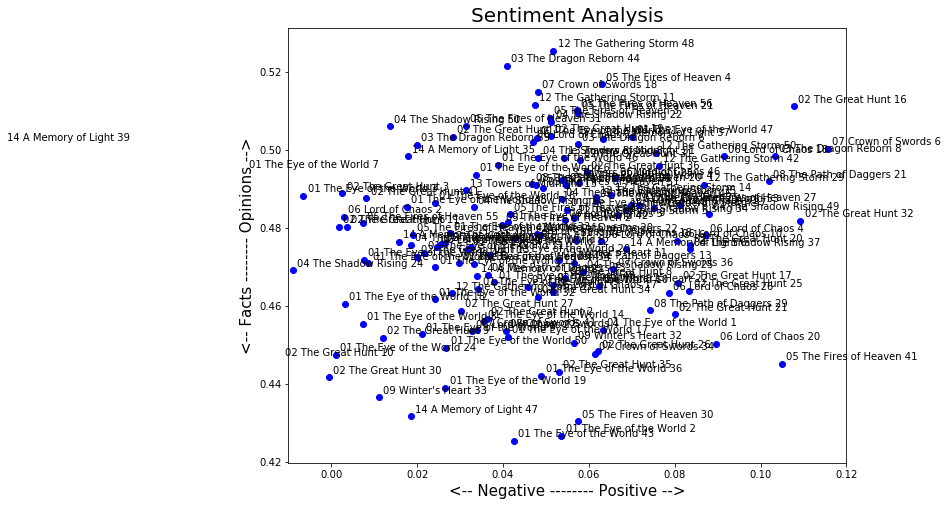

In [62]:
plt.rcParams['figure.figsize'] = [10, 8]

for index, chapter in enumerate(rand_books.index):
    x = rand_books.polarity.loc[chapter]
    y = rand_books.subjectivity.loc[chapter]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, rand_books.index[index], fontsize=10)
    plt.xlim(-.01, .12) 
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative -------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts -------- Opinions -->', fontsize=15)

plt.show()

In [63]:
import numpy as np
import math

def split_text(text, n=10):
    '''Takes in a string of text and splits into n equal parts, with a default of 10 equal parts.'''

    # Calculate length of text, the size of each chunk of text and the starting points of each chunk of text
    length = len(text)
    size = math.floor(length / n)
    start = np.arange(0, length, size)
    
    # Pull out equally sized pieces of text and put it into a list
    split_list = []
    for piece in range(n):
        split_list.append(text[start[piece]:start[piece]+size])
    return split_list

In [64]:
list_pieces = []
for t in rand_books.Chapter_Text:
    split = split_text(t)
    list_pieces.append(split)
    
list_pieces

[['1\nAn Empty RoadThe Wheel of Time turns, and Ages come and pass, leaving memories that become legend. Legend fades to myth, and even myth is long forgotten when the Age that gave it birth comes\n        again. Inone Age, called the Third Age by some, an Age yet to come, an Age long past, a wind rose in\n        theMountains of Mist. The wind was not the beginning. There are neither beginnings nor endings to\n        theturning of the Wheel of Time. But it was a beginning. Born below the ever cloud-capped peaks that gave the mountains their name, the wind blew east,\n      out across the Sand Hills, once the shore of a great ocean, before the Breaking of the World.\n        Down itflailed into the Two Rivers, into the tangled forest called the Westwood, and beat at two men\n        walkingwith a cart and horse down the rock-strewn track called the Quarry Road. For all that spring\n        shouldhave come a good month since, the wind carried an icy chill as if it would rather bear sno

In [65]:
len(list_pieces)

150

In [66]:
polarity_transcript = []
for lp in list_pieces:
    polarity_piece = []
    for p in lp:
        polarity_piece.append(TextBlob(p).sentiment.polarity)
    polarity_transcript.append(polarity_piece)
    
polarity_transcript

[[0.018150281618023553,
  0.015054035798716638,
  0.0041679125862799345,
  0.05826118326118328,
  0.12260860484544696,
  0.11268981481481483,
  0.06618650793650793,
  0.0743985438429883,
  0.10535893844717374,
  0.07537525879917185],
 [0.030326688815060895,
  0.16262254901960785,
  0.11022508193560825,
  0.041978458049886605,
  0.01087562129228796,
  -0.012937675070028024,
  0.10831949058693244,
  -0.06590501792114697,
  -0.01286764705882354,
  0.18219759168035027],
 [0.07923809523809525,
  0.01887755102040816,
  -0.1628824458902584,
  -0.09001823251823253,
  0.13415013227513228,
  -0.023965262379896553,
  0.006868720449172574,
  0.054130591630591626,
  -0.06054589598997492,
  0.06668526785714286],
 [0.02439123376623376,
  0.1330208333333333,
  0.047545129162776215,
  0.12523809523809526,
  0.01568152454780361,
  0.08253292806484298,
  -0.04930555555555556,
  0.16199874686716792,
  0.05233465608465608,
  0.009484126984126998],
 [-0.02688155136268344,
  0.09304392446633825,
  0.05125070

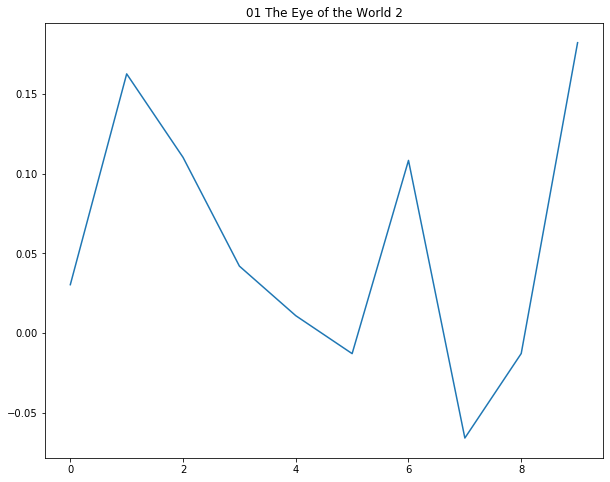

In [67]:
plt.plot(polarity_transcript[1])
plt.title(rand_books.index[1])
plt.show()

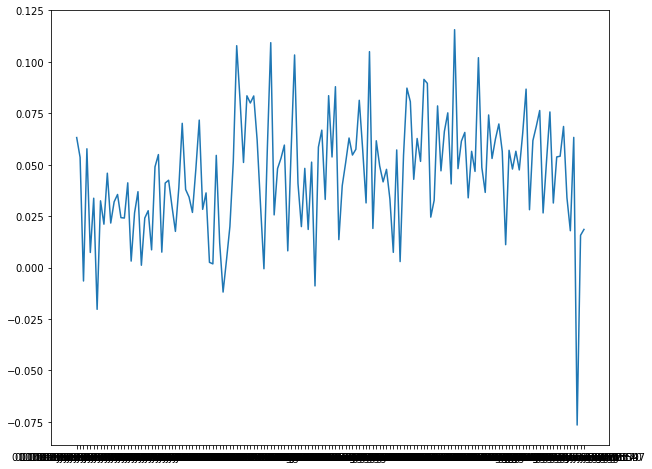

In [68]:
plt.plot(rand_books.polarity)
#plt.title(rand_books.index)
plt.show()

In [69]:
sent_df['Chapter_Text'] = sent_df['Chap_by_Sent'].apply(lambda x: " ".join(x))

In [70]:
sent_df['Chapter_Text'][2]

'strangerswhen rand and mat carried the first barrels through the common room , master alvere wasalready filling a pair of mugs with his best brown ale , his own make , from one of the casks rackedagainst one wall . scratch , the inns yellow cat , crouched atop it with his eyes closed and his tailwrapped around his feet . tam stood in front of the big fireplace of river rock , thumbing a long-stemmed pipe full of tabac from a polished canister the innkeeper always kept on the plain stonemantel . the fireplace stretched half the length of the big , square room , with a lintel as high as a mansshoulder , and the crackling blaze on the hearth vanquished the chill outside . at that time of the busy day before festival , rand expected to find the common room emptyexcept for bran and his father and the cat , but four more members of the village council , includingcenn , sat in high-backed chairs in front of the fire , mugs in hand and blue-gray pipesmoke wreathingtheir heads . for once none 

In [71]:
two_chap_df = sent_df.copy()

In [72]:
merged_df = pd.merge(two_chap_df, mean_sent, on=['Book_Title','Chapter_Number'])

In [73]:
merged_df = merged_df.rename(columns={'Sentence_Length': 'Mean_Sent_Length'})

In [74]:
merged_df['Book_Chap'] = merged_df['Book_Title'] + " " + merged_df['Chapter_Number'].astype(str)

merged_df = merged_df.set_index('Book_Chap')

In [75]:
merged_df

Book_Title  \
Book_Chap                                            
01 The Eye of the World 0  01 The Eye of the World   
01 The Eye of the World 1  01 The Eye of the World   
01 The Eye of the World 2  01 The Eye of the World   
01 The Eye of the World 3  01 The Eye of the World   
01 The Eye of the World 4  01 The Eye of the World   
...                                            ...   
14 A Memory of Light 48       14 A Memory of Light   
14 A Memory of Light 49       14 A Memory of Light   
14 A Memory of Light 50       14 A Memory of Light   
RobertJordan 0                        RobertJordan   
BrandonSandersonExtra 0      BrandonSandersonExtra   

                                                                Chapter_Text  \
Book_Chap                                                                      
01 The Eye of the World 0  prologue dragonmountthe palace still shook occ...   
01 The Eye of the World 1  an empty roadthe wheel of time turns , and age...   
01 The Eye of the World 2  strangerswhen rand and mat carried the first b...   
01 The Eye of the World 3  the peddlerclusters of pots clattered and bang...   
01 The Eye of the World 4  the gleemanthe door of the inn banged shut beh...   
...                                                                      ...   
14 A Memory of Light 48    she fought it off , but barely . the forsaken ...   
14 A Memory of Light 49    so many dead . hundreds of thousands of men an...   
14 A Memory of Light 50    beneath that was only emptiness . in the wolf ...   
RobertJordan 0             the wide corridor outside the amyrlin 's apart...   
BrandonSandersonExtra 0    dalinar kholin appeared in the vision standing...   

                          Chapter_Number  \
Book_Chap                                  
01 The Eye of the World 0              0   
01 The Eye of the World 1              1   
01 The Eye of the World 2              2   
01 The Eye of the World 3              3   
01 The Eye of the World 4              4   
...                                  ...   
14 A Memory of Light 48               48   
14 A Memory of Light 49               49   
14 A Memory of Light 50               50   
RobertJordan 0                         0   
BrandonSandersonExtra 0                0   

                                                                Chap_by_Sent  \
Book_Chap                                                                      
01 The Eye of the World 0  [prologue dragonmountthe palace still shook oc...   
01 The Eye of the World 1  [an empty roadthe wheel of time turns , and ag...   
01 The Eye of the World 2  [strangerswhen rand and mat carried the first ...   
01 The Eye of the World 3  [the peddlerclusters of pots clattered and ban...   
01 The Eye of the World 4  [the gleemanthe door of the inn banged shut be...   
...                                                                      ...   
14 A Memory of Light 48    [she fought it off , but barely ., the forsake...   
14 A Memory of Light 49    [so many dead ., hundreds of thousands of men ...   
14 A Memory of Light 50    [beneath that was only emptiness ., in the wol...   
RobertJordan 0             [the wide corridor outside the amyrlin 's apar...   
BrandonSandersonExtra 0    [dalinar kholin appeared in the vision standin...   

                                                                 Word_Tokens  \
Book_Chap                                                                      
01 The Eye of the World 0  [[prologue, dragonmountthe, palace, still, sho...   
01 The Eye of the World 1  [[an, empty, roadthe, wheel, of, time, turns, ...   
01 The Eye of the World 2  [[strangerswhen, rand, and, mat, carried, the,...   
01 The Eye of the World 3  [[the, peddlerclusters, of, pots, clattered, a...   
01 The Eye of the World 4  [[the, gleemanthe, door, of, the, inn, banged,...   
...                                                                      ...   
14 A Memory of Light 48    [[she, fought, 

In [76]:
def num_sent(sent_list):
    for sent in sent_list:
        if sent == '.':
            sent_list.remove(sent)
    return len(sent_list)

In [77]:
merged_df['Num_Sent'] = merged_df['Chap_by_Sent'].apply(num_sent)

In [78]:
merged_df

Book_Title  \
Book_Chap                                            
01 The Eye of the World 0  01 The Eye of the World   
01 The Eye of the World 1  01 The Eye of the World   
01 The Eye of the World 2  01 The Eye of the World   
01 The Eye of the World 3  01 The Eye of the World   
01 The Eye of the World 4  01 The Eye of the World   
...                                            ...   
14 A Memory of Light 48       14 A Memory of Light   
14 A Memory of Light 49       14 A Memory of Light   
14 A Memory of Light 50       14 A Memory of Light   
RobertJordan 0                        RobertJordan   
BrandonSandersonExtra 0      BrandonSandersonExtra   

                                                                Chapter_Text  \
Book_Chap                                                                      
01 The Eye of the World 0  prologue dragonmountthe palace still shook occ...   
01 The Eye of the World 1  an empty roadthe wheel of time turns , and age...   
01 The Eye of the World 2  strangerswhen rand and mat carried the first b...   
01 The Eye of the World 3  the peddlerclusters of pots clattered and bang...   
01 The Eye of the World 4  the gleemanthe door of the inn banged shut beh...   
...                                                                      ...   
14 A Memory of Light 48    she fought it off , but barely . the forsaken ...   
14 A Memory of Light 49    so many dead . hundreds of thousands of men an...   
14 A Memory of Light 50    beneath that was only emptiness . in the wolf ...   
RobertJordan 0             the wide corridor outside the amyrlin 's apart...   
BrandonSandersonExtra 0    dalinar kholin appeared in the vision standing...   

                          Chapter_Number  \
Book_Chap                                  
01 The Eye of the World 0              0   
01 The Eye of the World 1              1   
01 The Eye of the World 2              2   
01 The Eye of the World 3              3   
01 The Eye of the World 4              4   
...                                  ...   
14 A Memory of Light 48               48   
14 A Memory of Light 49               49   
14 A Memory of Light 50               50   
RobertJordan 0                         0   
BrandonSandersonExtra 0                0   

                                                                Chap_by_Sent  \
Book_Chap                                                                      
01 The Eye of the World 0  [prologue dragonmountthe palace still shook oc...   
01 The Eye of the World 1  [an empty roadthe wheel of time turns , and ag...   
01 The Eye of the World 2  [strangerswhen rand and mat carried the first ...   
01 The Eye of the World 3  [the peddlerclusters of pots clattered and ban...   
01 The Eye of the World 4  [the gleemanthe door of the inn banged shut be...   
...                                                                      ...   
14 A Memory of Light 48    [she fought it off , but barely ., the forsake...   
14 A Memory of Light 49    [so many dead ., hundreds of thousands of men ...   
14 A Memory of Light 50    [beneath that was only emptiness ., in the wol...   
RobertJordan 0             [the wide corridor outside the amyrlin 's apar...   
BrandonSandersonExtra 0    [dalinar kholin appeared in the vision standin...   

                                                                 Word_Tokens  \
Book_Chap                                                                      
01 The Eye of the World 0  [[prologue, dragonmountthe, palace, still, sho...   
01 The Eye of the World 1  [[an, empty, roadthe, wheel, of, time, turns, ...   
01 The Eye of the World 2  [[strangerswhen, rand, and, mat, carried, the,...   
01 The Eye of the World 3  [[the, peddlerclusters, of, pots, clattered, a...   
01 The Eye of the World 4  [[the, gleemanthe, door, of, the, inn, banged,...   
...                                                                      ...   
14 A Memory of Light 48    [[she, fought, 

In [79]:
def pos_tag_sent(sent_list):
    """ Splits the sentence into words and then tags them as parts of speech"""
    result = []
    for sent in sent_list:
        token_list = []
        tokens = pos_tag(word_tokenize(sent))
        for token in tokens:
            token_list.append(token[1])
        result.append(token_list)
    return result



In [80]:
def merge_sentences(sent_list):
    """ Remerges the sentences from the split words.  """
    result = ""
    for sent in sent_list:
        result += (" " + sent)
    return result
        

In [81]:
# Tag the words with the parts of speech and then return them to a string to use as a sentence.

merged_df['Parts_of_Speech'] = merged_df['Chap_by_Sent'].apply(pos_tag_sent)
merged_df['POS_String'] = merged_df['Parts_of_Speech'].apply(join_sent)
merged_df['POS_String'] = merged_df['POS_String'].apply(merge_sentences)

In [82]:
merged_df.to_csv('wot_clean.csv')